# Assignment 3 - Random Forest

Freek van Geffen | s2633256 <br>
Justin Kraaijenbrink | s2577984

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy.stats.mstats import zscore
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import KFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, mean_squared_error, explained_variance_score

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import sklearn.metrics as metrics
import pickle

## Regression

#### Import data and define helper functions

In [2]:
import os
path = os.getcwd()

housing = pd.read_csv(path + '/data/Housing.csv')

In [3]:
# Standardization function to obtain standardized regression coefficients 
# for the linear regression model
def Standardize(model, X_train, y_train, index):
    X_train = X_train.drop(columns = 'const')
    index = index.drop('const')
    
    sdy = np.std(y_train)
    sdx = np.std(X_train[index]).values
    coefs = model.params.drop('const')
    
    std_coefs = coefs.values / (sdy / sdx)
    
    out = pd.DataFrame(std_coefs, index = coefs.index, columns = ['Std. Beta']).sort_values(by = 'Std. Beta', ascending = False)
    
    return(out)

In [10]:
# Function to evaluate the performance of the models
def CalculateRMSE(model, X_test, y_test):
    y_pred = model.predict(X_test)
    
    mse = np.sum((y_pred - y_test)**2) / len(y_test)
    
    return np.sqrt(mse)

In [4]:
# Generate train and test set
np.random.RandomState(248)
y = housing['price']
X = housing.iloc[:, 1:]
X = pd.get_dummies(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 248)

#### Baseline model: linear regression

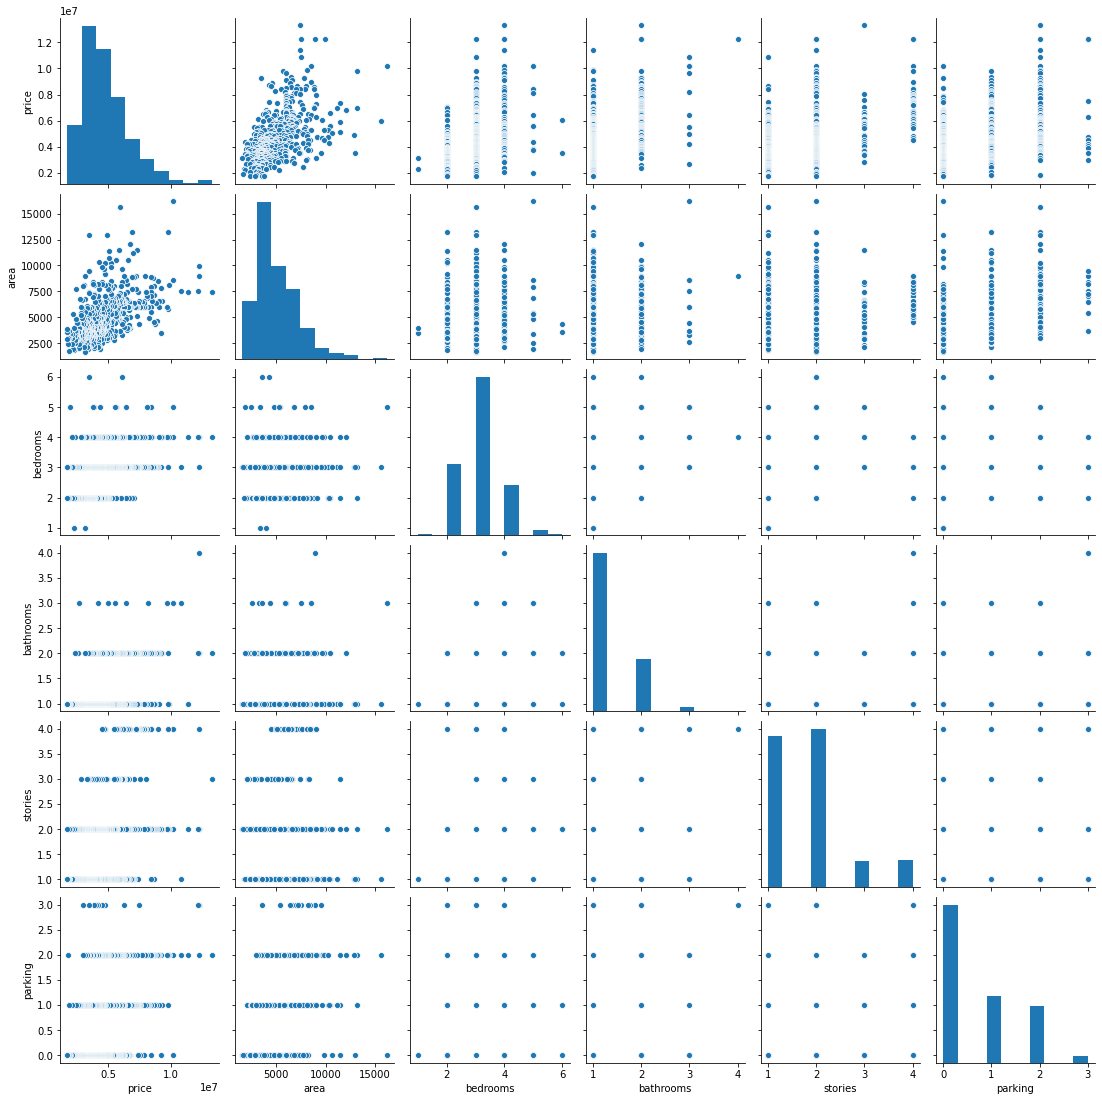

In [6]:
# Exploratory data analysis
sns.pairplot(housing)

In [7]:
# Baseline model
X_train_lr = X_train
X_train_lr = sm.add_constant(X_train_lr)
X_test_lr = X_test
X_test_lr = sm.add_constant(X_test_lr)

model = sm.OLS(y_train, X_train_lr)
fit = model.fit()
y_pred = fit.predict(X_test_lr)

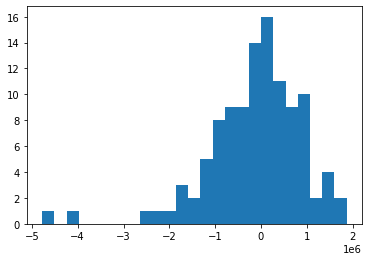

In [8]:
# Check for normality
errors = y_pred - y_test
plt.hist(errors, bins = 25)
plt.show()

In [9]:
# Inspect fit and select significant predictors
print(fit.summary())
preds = X_train_lr.columns[fit.summary2().tables[1]['P>|t|'] < 0.05]
index = preds.drop(['airconditioning_no', 'hotwaterheating_no', 'prefarea_no'])

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.686
Model:                            OLS   Adj. R-squared:                  0.676
Method:                 Least Squares   F-statistic:                     70.87
Date:                Thu, 10 Dec 2020   Prob (F-statistic):           2.27e-97
Time:                        20:54:25   Log-Likelihood:                -6667.1
No. Observations:                 436   AIC:                         1.336e+04
Df Residuals:                     422   BIC:                         1.342e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

In [10]:
# Fit final model
finalmodel = sm.OLS(y_train, X_train_lr[index])
finalfit = finalmodel.fit()

In [11]:
# Obtain fit measures RMSE and explained variance
reg_rmse = CalculateRMSE(finalfit, X_test_lr[index], y_test)
reg_r2 = finalfit.rsquared
print(reg_rmse, reg_r2)

1048186.3383284962 0.6842244815603398


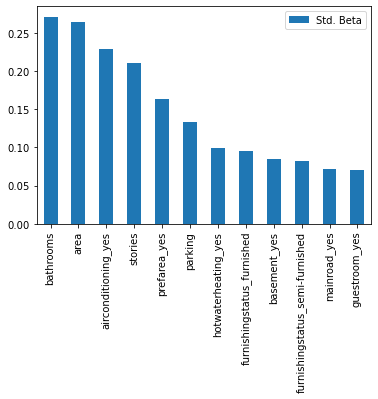

In [12]:
# Obtain standardized coefficients to assess variable importance
std_coefs = Standardize(finalfit, X_train_lr, y_train, index)
abs(std_coefs).plot(kind = 'bar')
plt.show()

#### Random forest

In [13]:
# Define grid with parameter values
RandomGrid = {
    'n_estimators' : [int(x) for x in np.linspace(200, 2000, num = 10)],
    'max_depth' : [int(x) for x in np.linspace(10, 150, num = 15)],
    'min_samples_split' : [2, 5, 10],
    'min_samples_leaf' : [1, 2, 4, 8],
    'bootstrap' : [True, False]
}

In [14]:
# Create baseline model
rfr = RandomForestRegressor()

# Search across all parameter combinations and randomly pick 100
np.random.RandomState(248)
rfr_random = RandomizedSearchCV(estimator = rfr, param_distributions = RandomGrid,
                                n_iter = 100, cv = 5, scoring = 'neg_root_mean_squared_error',
                                random_state = 248, n_jobs = -1)

# Fit the CV model
rfr_random.fit(X_train, y_train)

In [ ]:
# Obtain best parameters
rfr_random.best_params_

In [23]:
# Perform second, more local gridsearch around best parameter values
RandomGrid2 = {
    'n_estimators' : [int(x) for x in np.linspace(100, 500, num = 5)],
    'max_depth' : [int(x) for x in np.linspace(120, 140, num = 3)],
    'min_samples_split' : [3, 5, 7],
    'min_samples_leaf' : [1, 2, 3],
    'bootstrap' : [True, False]
}

np.random.RandomState(248)
rfr_random2 = RandomizedSearchCV(estimator = rfr, param_distributions = RandomGrid2,
                                n_iter = 100, cv = 5, scoring = 'neg_root_mean_squared_error',
                                random_state = 248, n_jobs = -1)

rfr_random2.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [120, 130, 140],
                                        'min_samples_leaf': [1, 2, 3],
                                        'min_samples_split': [3, 5, 7],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500]},
                   random_state=248, scoring='neg_root_mean_squared_error')

In [24]:
rfr_random2.best_params_

{'n_estimators': 200,
 'min_samples_split': 7,
 'min_samples_leaf': 3,
 'max_depth': 140,
 'bootstrap': True}

In [29]:
# Fit final model on validation set
rfr_final = rfr_random2.best_estimator_
rfr_final.fit(X_train, y_train)
y_pred = rfr_final.predict(X_test)

print(CalculateRMSE(rfr_final, X_test, y_test))
print(explained_variance_score(y_test, y_pred))

1121292.9141936472
0.6232384550277634


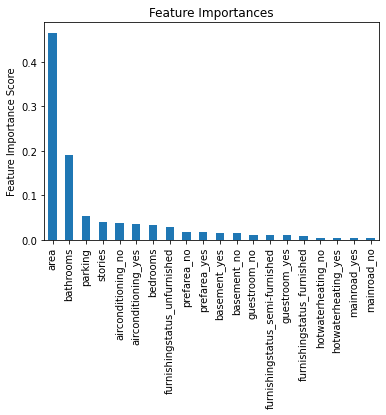

In [19]:
# Plot feature importances
features = pd.Series(rfr_final.feature_importances_, index = X_train.columns)
features.nlargest(20).plot(kind = 'bar', title = 'Feature Importances')
plt.ylabel('Feature Importance Score')
plt.show()

Some visualizations on the tuning of hyperparameters

In [18]:
def PlotTuningResults(model, parameter, name):
    param_name = 'param_' + parameter
    
    test_scores = abs(model.cv_results_['mean_test_score'])
    param_values = list(model.cv_results_[param_name])
    
    fig= plt.figure(figsize = (12, 8))
    plt.plot(param_values, test_scores)
    plt.ylabel('Test explained variance', size = 20)
    plt.xlabel(name, size = 20)
    plt.yticks(size = 20)
    plt.xticks(param_values, size = 14)
    plt.title('Accuracy vs. ' + name, size = 24)
    plt.tight_layout(pad = 4)

In [ ]:
# Number of trees
TreeGrid = {'n_estimators' : [int(x) for x in np.linspace(200, 2000, num = 19)]}

TreeGrid_search = GridSearchCV(rfr_final, param_grid = TreeGrid, cv = 5,
                               scoring = 'explained_variance', n_jobs = -1)

TreeGrid_search.fit(X_train, y_train)

In [19]:
# Max depth
DepthGrid = {'max_depth' : [int(x) for x in np.linspace(10, 190, num = 19)]}

DepthGrid_search = GridSearchCV(rfr_final, param_grid = DepthGrid, cv = 5, 
                                scoring = 'explained_variance', n_jobs = -1)

DepthGrid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestRegressor(max_depth=120, min_samples_leaf=3,
                                             min_samples_split=3,
                                             n_estimators=200),
             n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100,
                                       110, 120, 130, 140, 150, 160, 170, 180,
                                       190]},
             scoring='explained_variance')

In [20]:
# Min samples split
MinSplitGrid = {'min_samples_split' : [int(x) for x in np.linspace(2, 20, num = 19)]}

MinSplitGrid_search = GridSearchCV(rfr_final, param_grid = MinSplitGrid, cv = 5,
                                   scoring = 'explained_variance', n_jobs = -1)

MinSplitGrid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestRegressor(max_depth=120, min_samples_leaf=3,
                                             min_samples_split=3,
                                             n_estimators=200),
             n_jobs=-1,
             param_grid={'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                               12, 13, 14, 15, 16, 17, 18, 19,
                                               20]},
             scoring='explained_variance')

In [21]:
# Min samples leaf
MinLeafGrid = {'min_samples_leaf' : [int(x) for x in np.linspace(2, 20, num = 19)]}

MinLeafGrid_search = GridSearchCV(rfr_final, param_grid = MinLeafGrid, cv = 5,
                                  scoring = 'explained_variance', n_jobs = -1)

MinLeafGrid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestRegressor(max_depth=120, min_samples_leaf=3,
                                             min_samples_split=3,
                                             n_estimators=200),
             n_jobs=-1,
             param_grid={'min_samples_leaf': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15, 16, 17, 18, 19,
                                              20]},
             scoring='explained_variance')

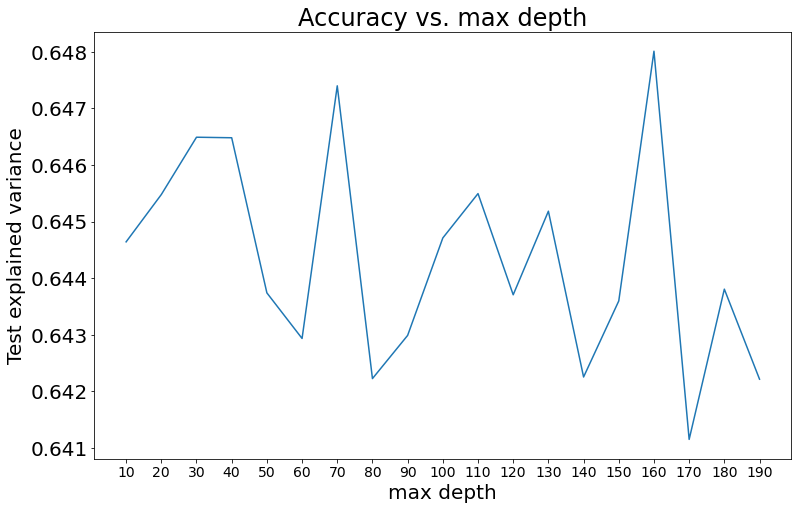

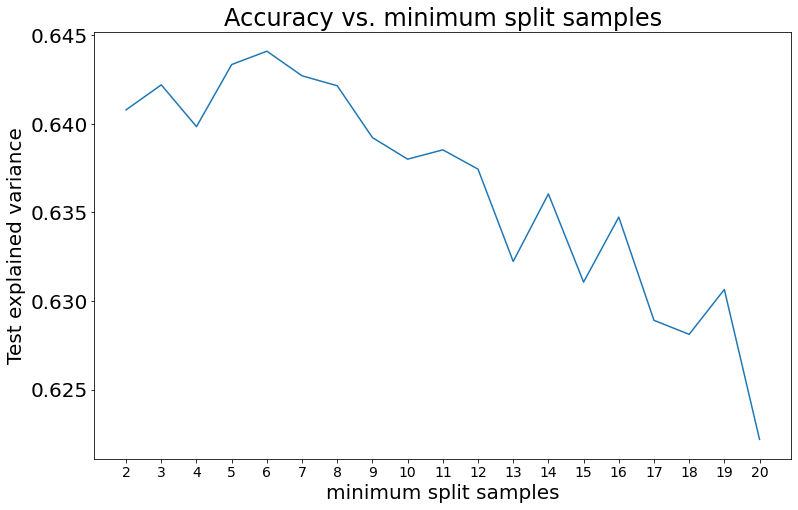

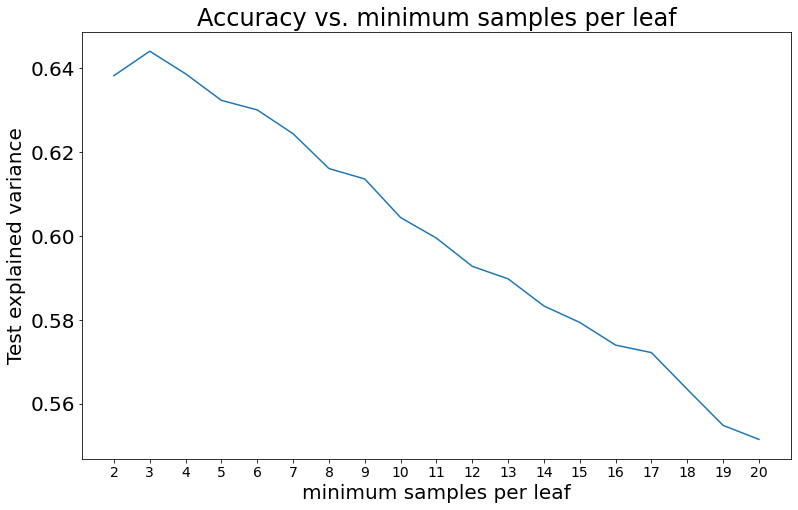

In [22]:
PlotTuningResults(TreeGrid_search, 'n_estimators', 'number of trees')

PlotTuningResults(DepthGrid_search, 'max_depth', 'max depth')

PlotTuningResults(MinSplitGrid_search, 'min_samples_split', 'minimum split samples')

PlotTuningResults(MinLeafGrid_search, 'min_samples_leaf', 'minimum samples per leaf')

## Classification

#### Import data and aggregate datasets

In [21]:
gene_proteins = pd.read_csv(path+'/data/PAM50_proteins.csv')
clinical = pd.read_csv(path+'/data/clinical_data_breast_cancer.csv')
proteomes = pd.read_csv(path+'/data/77_cancer_proteomes_CPTAC_itraq.csv')

In [22]:
n = proteomes.index.values
proteomes_trans = proteomes.iloc[:,3:].T
TCGA_ids = pd.DataFrame({"Complete TCGA ID":proteomes_trans.index.values})
proteomes_trans.reset_index(inplace = True)
proteomes_trans.columns.values[0] = 'Complete TCGA ID'

In [23]:
def ReformatID(ID):
    
    x = ID[3:7]
    y = ID[0:2]
    out = 'TCGA'+'-'+y+'-'+ x
    
    return(out)

In [24]:
# Data preprocessing
proteomes_trans.iloc[:,0] = [ReformatID(element) for element in proteomes_trans.iloc[:,0]]
proteomes_final = proteomes_trans.dropna(axis = 1)
data = clinical.merge(proteomes_final, on = 'Complete TCGA ID')

objects = data.dtypes[data.dtypes == object].index.values
data_fact = data.copy(deep = True)

for i in objects:
    data_fact.loc[:, i] = pd.factorize(data_fact.loc[:, i])[0]

In [25]:
# Generate train and test set
seed = np.random.RandomState(248)
y = data_fact['PAM50 mRNA']
X = data_fact.iloc[:, 30:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 248)

#### Exploratory data analysis

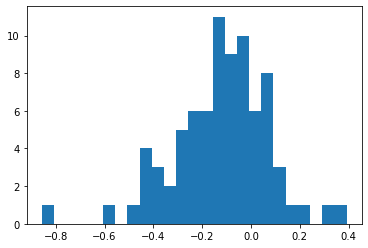

In [26]:
# Patient protein averages
plt.hist(X.mean(axis = 1), bins = 25)
plt.show()

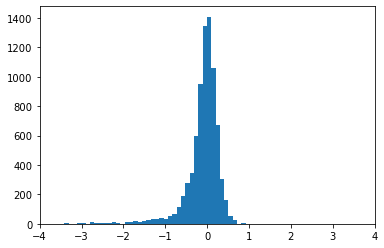

In [27]:
# Protein averages
plt.hist(X.mean(axis = 0), bins = 100)
plt.xlim(-4, 4)
plt.show()

#### Baseline model: multinomial logistic lasso regression

In [28]:
# Fit model on the train data
lassoreg = LogisticRegression(penalty = 'l1', fit_intercept = False, random_state = 248,
                             multi_class = 'multinomial', solver = 'saga', max_iter = 1e5)

lassoreg.fit(X_train, y_train)

LogisticRegression(fit_intercept=False, max_iter=100000.0,
                   multi_class='multinomial', penalty='l1', random_state=248,
                   solver='saga')

In [29]:
# Make predictions and determine classification accuracy
y_pred = lassoreg.predict(X_test)
accuracy = sum(y_pred == y_test) / len(y_test)
print(accuracy)

0.75


#### Random Forest

In [30]:
# Define function to obtain accuracy 
def EvaluateRF(model, X_test, y_test):
    y_pred = model.predict(X_test)
    
    accuracy = np.sum(y_pred == y_test) / len(y_test)
    
    return accuracy

In [31]:
# Define grid with parameter values
RandomGrid = {
    'n_estimators' : [int(x) for x in np.linspace(200, 2000, num = 10)],
    'max_depth' : [int(x) for x in np.linspace(10, 150, num = 15)],
    'min_samples_split' : [2, 5, 10],
    'min_samples_leaf' : [1, 2, 4, 8],
    'bootstrap' : [True, False]
}

In [32]:
# Create baseline model
rfc = RandomForestClassifier()

# Search across all parameter combinations and randomly pick 100
np.random.RandomState(248)
rfc_random = RandomizedSearchCV(estimator = rfc, param_distributions = RandomGrid,
                                n_iter = 100, scoring = 'accuracy', cv = 5, 
                                random_state = 248, n_jobs = -1)

# Fit the CV model
rfc_random.fit(X_train, y_train)

In [ ]:
# Obtain best parameters
rfc_random.best_params_

In [33]:
# Perform second, more local gridsearch around best parameter values
RandomGrid2 = {
    'n_estimators' : [int(x) for x in np.linspace(100, 400, num = 4)],
    'max_depth' : [int(x) for x in np.linspace(90, 110, num = 3)],
    'min_samples_split' : [3, 5, 7],
    'min_samples_leaf' : [1, 2, 3],
    'bootstrap' : [True, False]
}

np.random.RandomState(248)
rfc_random2 = RandomizedSearchCV(estimator = rfc, param_distributions = RandomGrid2,
                                n_iter = 100, scoring = 'accuracy', cv = 5, 
                                random_state = 248, n_jobs = -1)

rfc_random2.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [90, 100, 110],
                                        'min_samples_leaf': [1, 2, 3],
                                        'min_samples_split': [3, 5, 7],
                                        'n_estimators': [100, 200, 300, 400]},
                   random_state=248, scoring='accuracy')

In [34]:
rfc_random2.best_params_

{'n_estimators': 100,
 'min_samples_split': 3,
 'min_samples_leaf': 2,
 'max_depth': 90,
 'bootstrap': True}

In [35]:
# Fit final model on validation set
rfc_final = rfc_random2.best_estimator_
rfc_final.fit(X_train, y_train)

EvaluateRF(rfc_final, X_test, y_test)

0.875

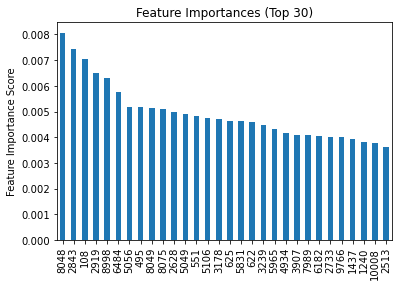

In [37]:
# Plot feature importances
features = pd.Series(rfc_final.feature_importances_, index = X_train.columns)
features.nlargest(30).plot(kind = 'bar', title = 'Feature Importances (Top 30)')
plt.ylabel('Feature Importance Score')
plt.show()

In [38]:
def PlotTuningResults(model, parameter, name):
    param_name = 'param_' + parameter
    
    test_scores = model.cv_results_['mean_test_score']
    param_values = list(model.cv_results_[param_name])
    
    fig= plt.figure(figsize = (12, 8))
    plt.plot(param_values, test_scores)
    plt.ylim(ymin = 0, ymax = 1)
    plt.ylabel('Test accuracy', size = 20)
    plt.xlabel(name, size = 20)
    plt.yticks(size = 20)
    plt.xticks(param_values, size = 14)
    plt.title('Accuracy vs. ' + name, size = 24)
    plt.tight_layout(pad = 4)

In [39]:
# Number of trees
TreeGrid = {'n_estimators' : [int(x) for x in np.linspace(200, 2000, num = 19)]}

TreeGrid_search = GridSearchCV(rfc_final, param_grid = TreeGrid, cv = 5,
                               scoring = 'accuracy', n_jobs = -1)

TreeGrid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(max_depth=90, min_samples_leaf=2,
                                              min_samples_split=3),
             n_jobs=-1,
             param_grid={'n_estimators': [200, 300, 400, 500, 600, 700, 800,
                                          900, 1000, 1100, 1200, 1300, 1400,
                                          1500, 1600, 1700, 1800, 1900, 2000]},
             scoring='accuracy')

In [40]:
# Max depth
DepthGrid = {'max_depth' : [int(x) for x in np.linspace(10, 100, num = 19)]}

DepthGrid_search = GridSearchCV(rfc_final, param_grid = DepthGrid, cv = 5,
                               scoring = 'accuracy', n_jobs = -1)

DepthGrid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(max_depth=90, min_samples_leaf=2,
                                              min_samples_split=3),
             n_jobs=-1,
             param_grid={'max_depth': [10, 15, 20, 25, 30, 35, 40, 45, 50, 55,
                                       60, 65, 70, 75, 80, 85, 90, 95, 100]},
             scoring='accuracy')

In [41]:
# Min samples split
MinSplitGrid = {'min_samples_split' : [int(x) for x in np.linspace(2, 20, num = 19)]}

MinSplitGrid_search = GridSearchCV(rfc_final, param_grid = MinSplitGrid, cv = 5,
                               scoring = 'accuracy', n_jobs = -1)

MinSplitGrid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(max_depth=90, min_samples_leaf=2,
                                              min_samples_split=3),
             n_jobs=-1,
             param_grid={'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                               12, 13, 14, 15, 16, 17, 18, 19,
                                               20]},
             scoring='accuracy')

In [42]:
# Min samples split
MinLeafGrid = {'min_samples_leaf' : [int(x) for x in np.linspace(2, 20, num = 19)]}

MinLeafGrid_search = GridSearchCV(rfc_final, param_grid = MinLeafGrid, cv = 5,
                               scoring = 'accuracy', n_jobs = -1)

MinLeafGrid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(max_depth=90, min_samples_leaf=2,
                                              min_samples_split=3),
             n_jobs=-1,
             param_grid={'min_samples_leaf': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15, 16, 17, 18, 19,
                                              20]},
             scoring='accuracy')

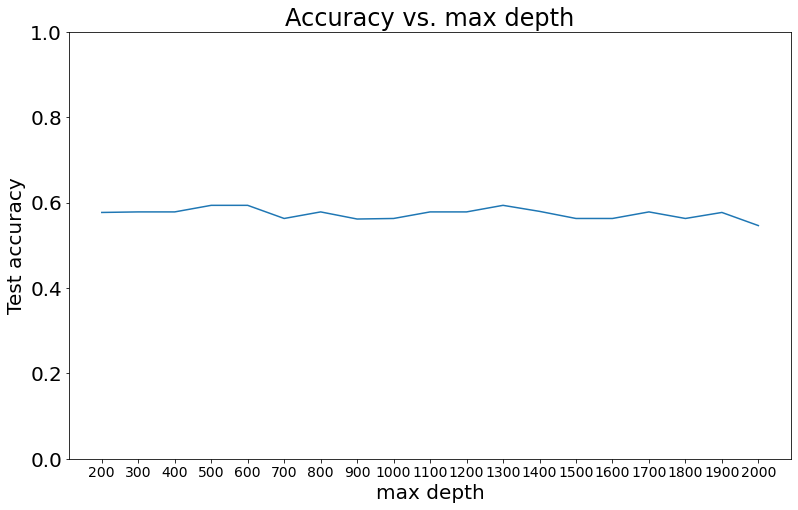

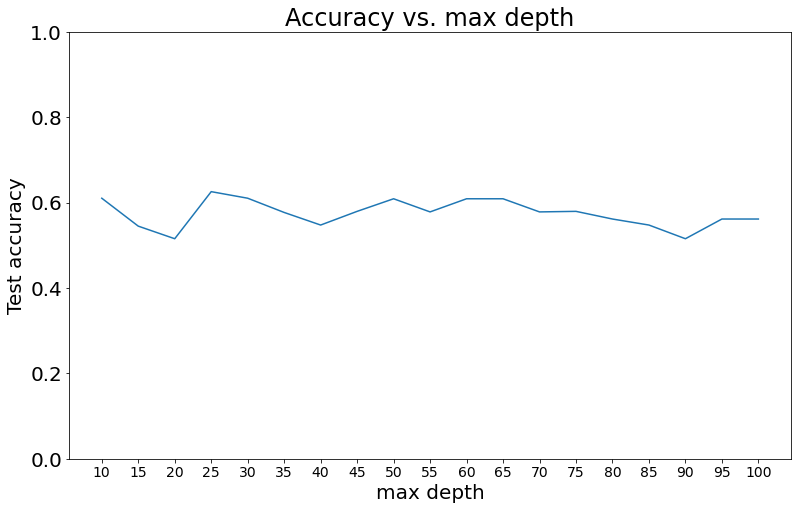

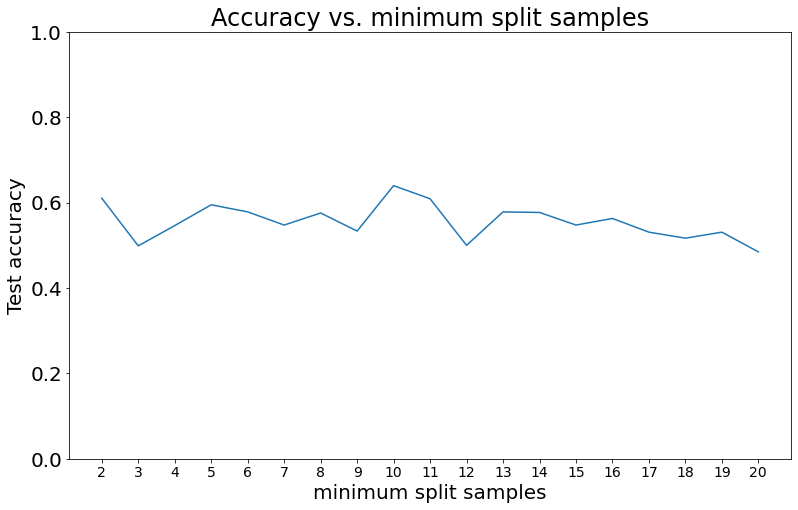

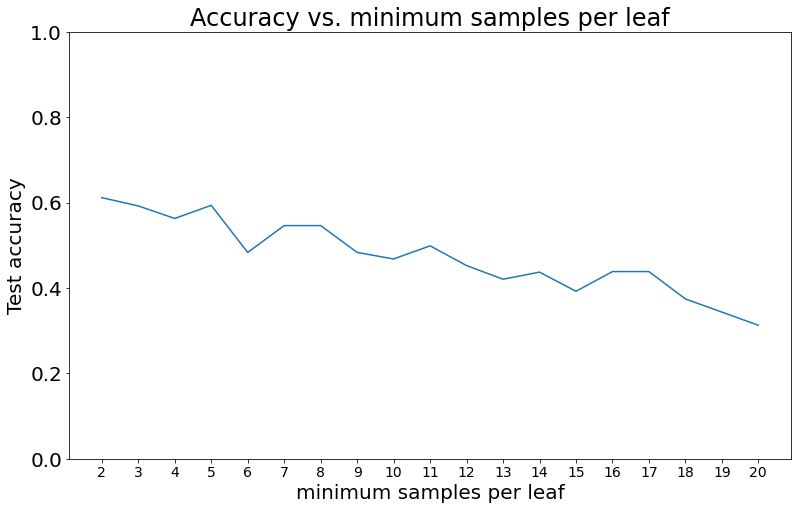

In [43]:
PlotTuningResults(TreeGrid_search, 'n_estimators', 'max depth')

PlotTuningResults(DepthGrid_search, 'max_depth', 'max depth')

PlotTuningResults(MinSplitGrid_search, 'min_samples_split', 'minimum split samples')

PlotTuningResults(MinLeafGrid_search, 'min_samples_leaf', 'minimum samples per leaf')